In [ ]:
!pip install dask

In [ ]:
import requests
from bs4 import BeautifulSoup #supports css selectors to select elements
import pandas as pd
import time
import re
import dask
from dask import dataframe as ddf

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
#url = 'https://www.amazon.com.au/Champions-76919-Buildable-Playable-Independent/dp/B0CFVWTFN6/ref=sr_1_2?adgrpid=161252662012&dib=eyJ2IjoiMSJ9.-0LhGAQm8YfdW3gJN7jtMaLQ2FGaeNfOZpCakyr5_GQ4xj2LIt_p-zeDAgYiBJrt0ce8guC455odaWlUM2D6Oimud4yoKjpU8P79iDg_1rYa3kaufRkCpcIW3pDymtNJA6BY1aBLQnzG8GBCxZIeSBDDtwcGdk38SxE9SbZNKoMwKMPmTy5rfn9GW0tY-yPJp39y2NbOnHDXOFi4Fy2yRb0hLUTxC4uwpcRK_p7C6hKsXVaHMYBZdr4WeBYG-afnrmjciIsDn-337hcq-aCJ9C7x3q-R3bXlnH1tU5zEJH4.1yuD0HseEHLMY8VaHmIrp23VdYiSigt8ySGJvFgUeIE&dib_tag=se&hvadid=682253302956&hvdev=c&hvlocphy=1011065&hvnetw=g&hvqmt=b&hvrand=15732196244302151273&hvtargid=kwd-23894836&hydadcr=11035_532083&keywords=lego+com&qid=1723092988&sr=8-2'

In [ ]:
#to fix 503 error:
custom_headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36 OPR/109.0.0.0',
                  'Accept-Language':'en-US,en;q=0.9'}

In [ ]:
response = requests.get(url, headers=custom_headers)

<!doctype html><html lang="en-au" class="a-no-js" data-19ax5a9jf="dingo"><!-- sp:feature:head-start -->
<head><script>var aPageStart = (new Date()).getTime();</script><meta charset="utf-8"/>
<!-- sp:end-feature:head-start -->
<!-- sp:feature:csm:head-open-part1 -->

<script type='text/javascript'>var ue_t0=ue_t0||+new Date();</script>
<!-- sp:end-feature:csm:head-open-part1 -->
<!-- sp:feature:cs-optimization -->
<meta http-equiv='x-dns-prefetch-control' content='on'>
<link rel="dns-prefetch" href="https://images-fe.ssl-images-amazon.com">
<link rel="dns-prefetch" href="https://m.media-amazon.com">
<link rel="dns-prefetch" href="https://completion.amazon.com">
<!-- sp:end-feature:cs-optimization -->
<!-- sp:feature:csm:head-open-part2 -->
<script type='text/javascript'>
window.ue_ihb = (window.ue_ihb || window.ueinit || 0) + 1;
if (window.ue_ihb === 1) {

var ue_csm = window,
    ue_hob = +new Date();
(function(d){var e=d.ue=d.ue||{},f=Date.now||function(){return+new Date};e.d=function
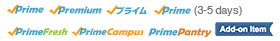

In [ ]:
print(response.text)

In [ ]:
print(response.status_code)

200


Iterate through each product on Amazon and on each product iterate through each page of reviews.

In [ ]:

def get_product_links(search_url):

    product_links = []
    page = 1

    while True:
        url = f"{search_url}&page={page}"
        response = requests.get(url, headers=custom_headers)
        soup = BeautifulSoup(response.content, "html.parser")

        product_elements = soup.select(".s-main-slot .a-link-normal.a-text-normal")

        if not product_elements:
            break

        for product_element in product_elements:
            link = "https://www.amazon.com.au" + product_element["href"]
            product_links.append(link)


        print(f"Scraped page {page} for product links")
        page += 1

        next_page = soup.select_one(".s-pagination-next")
        if not next_page or "disabled" in next_page.attrs:
            break

        time.sleep(1)  # Avoid overloading server

    return product_links


def scrape_reviews(review_base_url, set_id):
    """ Scrape reviews and ratings for a product and get set id per product """

    reviews = []
    page = 1

    while True:
        url = f"{review_base_url}&pageNumber={page}"
        response = requests.get(url, headers=custom_headers)
        soup = BeautifulSoup(response.content, "html.parser")

        review_elements = soup.select(".review")

        if not review_elements:
            break

        for review_element in review_elements:
            title_element = review_element.select_one(".review-title")
            date_element = review_element.select_one(".review-date")
            content_element = review_element.select_one(".review-text-content span")
            rating_element = review_element.select_one(".review-rating")

            title = title_element.get_text(strip=True) if title_element else "No Title"
            date = date_element.get_text(strip=True) if date_element else "No Date"
            content = content_element.get_text(strip=True) if content_element else "No Content"
            rating = int(rating_element.get_text(strip=True)[0]) if rating_element else -1  # Extract first digit for rating

            reviews.append({
                "set_id": set_id,
                "title": title,
                "date": date,
                "content": content,
                "rating": rating,
                "num_pieces": num_pieces,
                "manufacturer_recommended age": recommended_age,
                "release_date": release_date,
                "date_first_available": date_first_available
            })

        print(f"Scraped reviews from page {page}")
        page += 1

        next_page = soup.select_one("li.a-last a")
        if not next_page or 'href' not in next_page.attrs:
            print(f"No more pages found for reviews.")
            break

        time.sleep(1)

    return reviews

def get_table(link):
  response = requests.get(link, headers=custom_headers)
  soup = BeautifulSoup(response.content, "html.parser")

  table = soup.find("table", {"id": "productDetails_techSpec_section_1"})


  rows = table.find_all("tr") if table else []

  details = []

  for row in rows:
      # Extract the key and value for each row
      key = row.find("th").text.strip()
      value = row.find("td").text.strip()

      details.append((key, value))

  #print(details)

  table2 = soup.find("table", {"id": "productDetails_detailBullets_sections1"})
  #print(table2)
  rows = table2.find_all("tr") if table2 else []

  details2 = []

  for row in rows:
      # Extract the key and value for each row
      key = row.find("th").text.strip()
      value = row.find("td").text.strip()

      details2.append((key, value))
  #print(details2)

  set_id = -1
  release_date = 'NA'
  num_pieces = -1
  date_first_available = 'NA'
  recommended_age = ''

  for row in details:
    if row[0] == 'Model Number':
      set_id = row[1]
    elif row[0] == 'Item model number':
      set_id = row[1]
    elif row[0] == 'Release date':
      release_date = row[1]
    elif row[0] == 'Number of pieces':
      num_pieces = row[1]
    elif row[0] == 'Date first available':
      date_first_available = row[1]
    elif row[0] == 'Manufacturer recommended age':
      recommended_age = row[1]

  for row in details2:
    if row[0] == 'Date First Available':
      date_first_available = row[1]


  return (set_id, release_date, num_pieces, recommended_age, date_first_available)


search_url = "https://www.amazon.com.au/s?k=lego+com&language=en_AU&adgrpid=161252662012&hvadid=682253302959&hvdev=c&hvlocphy=9121940&hvnetw=g&hvqmt=b&hvrand=11848375806694944187&hvtargid=kwd-23894836&hydadcr=11035_446419&tag=nztxtgostdde-22&ref=pd_sl_9dv16jdait_b"

# Get all product links
product_links = get_product_links(search_url)
print(f"Total products found: {len(product_links)}")

all_reviews = []

for product_link in product_links:
    set_id, release_date, num_pieces, recommended_age, date_first_available = get_table(product_link)

    print(f"Scraping reviews for set_id: {set_id}")

    response = requests.get(product_link, headers=custom_headers)
    soup = BeautifulSoup(response.content, "html.parser")

    review_link_element = soup.select_one("a[data-hook='see-all-reviews-link-foot']")
    if not review_link_element:
        continue

    review_base_url = "https://www.amazon.com.au" + review_link_element["href"]

    # Scrape all reviews for this product without separate loops for each star rating
    product_reviews = scrape_reviews(review_base_url, set_id)
    all_reviews.extend(product_reviews)

    time.sleep(1)

df = pd.DataFrame(all_reviews)
print(df)


Scraped page 1 for product links
Scraped page 2 for product links
Scraped page 3 for product links
Scraped page 4 for product links
Scraped page 5 for product links
Scraped page 6 for product links
Total products found: 382
Scraping reviews for set_id: ‎76919
Scraped reviews from page 1
Scraped reviews from page 2
Scraped reviews from page 3
Scraped reviews from page 4
Scraped reviews from page 5
Scraped reviews from page 6
Scraped reviews from page 7
Scraped reviews from page 8
Scraped reviews from page 9
Scraped reviews from page 10
No more pages found for reviews.
Scraping reviews for set_id: ‎21335
Scraped reviews from page 1
Scraped reviews from page 2
Scraped reviews from page 3
Scraped reviews from page 4
Scraped reviews from page 5
Scraped reviews from page 6
Scraped reviews from page 7
Scraped reviews from page 8
Scraped reviews from page 9
Scraped reviews from page 10
No more pages found for reviews.
Scraping reviews for set_id: ‎21335
Scraped reviews from page 1
Scraped revi

In [ ]:
print(df['set_id'].dtype) #need to convert this to int

object


In [ ]:
df = df.dropna()

In [ ]:
print(df)

      set_id                                              title  \
0      76919   5.0 out of 5 starsEasy to put together great fun   
1      76919                       5.0 out of 5 starsGreat lego   
2      76919  5.0 out of 5 starsJust as good as the bigger one.   
3      76919               5.0 out of 5 starsGreat Lego product   
4      76919                        5.0 out of 5 starsExcellent   
...      ...                                                ...   
12748  11001                                  Too small package   
12749  11001                                             Ottimo   
12750  11001                                             Ottimo   
12751  11001                                               Good   
12752  11001                         Improvement in description   

                                          date  \
0      Reviewed in Australia on 16 August 2024   
1        Reviewed in Australia on 19 July 2024   
2        Reviewed in Australia on 19 June 202

In [ ]:
df['num_pieces'] = df['num_pieces'].str.replace(r'\D', '', regex=True)  # Removes invisible chars
df['num_pieces'] = df['num_pieces'].astype(int)

In [ ]:
df['title'] = df['title'].astype(str)
df['manufacturer_recommended age'] = df['manufacturer_recommended age'].astype(str)
df['release_date'] = df['release_date'].astype(str)

In [ ]:
print(df['title'].dtype)

object


In [ ]:
dask_data = ddf.from_pandas(df, npartitions=1)

In [ ]:
print(dask_data)
print(dask_data.head())

Dask DataFrame Structure:
               set_id   title    date content rating num_pieces manufacturer_recommended age release_date date_first_available
npartitions=1                                                                                                                 
0              string  string  string  string  int64      int64                       string       string               string
12752             ...     ...     ...     ...    ...        ...                          ...          ...                  ...
Dask Name: to_pyarrow_string, 2 graph layers
  set_id                                              title  \
0  76919   5.0 out of 5 starsEasy to put together great fun   
1  76919                       5.0 out of 5 starsGreat lego   
2  76919  5.0 out of 5 starsJust as good as the bigger one.   
3  76919               5.0 out of 5 starsGreat Lego product   
4  76919                        5.0 out of 5 starsExcellent   

                                      date

In [ ]:
dask_data = dask_data.astype({"title": str}).set_index('title')

In [ ]:
print(dask_data.head())

                                                     set_id  \
title                                                         
!ATTENZIONE!! app non per tutti.                      70418   
" It's amazing to watch them use the picture in...  6213583   
" It's amazing to watch them use the picture in...  6213583   
"Lego"-Qualität in Bestform                           10265   
#Love LEGO Star Wars                                  75357   

                                                                                                 date  \
title                                                                                                   
!ATTENZIONE!! app non per tutti.                                Reviewed in Italy on 27 December 2019   
" It's amazing to watch them use the picture in...     Reviewed in the United States on 16 April 2018   
" It's amazing to watch them use the picture in...     Reviewed in the United States on 16 April 2018   
"Lego"-Qualität in Bestform      

In [ ]:
print(dask_data)

Dask DataFrame Structure:
                                              set_id    date content rating num_pieces manufacturer_recommended age release_date date_first_available
npartitions=1                                                                                                                                        
!ATTENZIONE!! app non per tutti.              string  string  string  int64      int64                       string       string               string
🧱🧱 Teures Star Wars-Diorama vom Podrennen 🧱🧱     ...     ...     ...    ...        ...                          ...          ...                  ...
Dask Name: sort_index, 6 graph layers


In [ ]:
dask_data = dask_data[dask_data['set_id'].apply(lambda x: len(str(x)) <= 12, meta=('set_id', 'bool'))]

print(dask_data.head())

                                                     set_id  \
title                                                         
!ATTENZIONE!! app non per tutti.                      70418   
" It's amazing to watch them use the picture in...  6213583   
" It's amazing to watch them use the picture in...  6213583   
"Lego"-Qualität in Bestform                           10265   
#Love LEGO Star Wars                                  75357   

                                                                                                 date  \
title                                                                                                   
!ATTENZIONE!! app non per tutti.                                Reviewed in Italy on 27 December 2019   
" It's amazing to watch them use the picture in...     Reviewed in the United States on 16 April 2018   
" It's amazing to watch them use the picture in...     Reviewed in the United States on 16 April 2018   
"Lego"-Qualität in Bestform      

In [ ]:
dask_data['set_id'] = dask_data['set_id'].astype('Int64')

print(dask_data.head())

                                                     set_id  \
title                                                         
!ATTENZIONE!! app non per tutti.                      70418   
" It's amazing to watch them use the picture in...  6213583   
" It's amazing to watch them use the picture in...  6213583   
"Lego"-Qualität in Bestform                           10265   
#Love LEGO Star Wars                                  75357   

                                                                                                 date  \
title                                                                                                   
!ATTENZIONE!! app non per tutti.                                Reviewed in Italy on 27 December 2019   
" It's amazing to watch them use the picture in...     Reviewed in the United States on 16 April 2018   
" It's amazing to watch them use the picture in...     Reviewed in the United States on 16 April 2018   
"Lego"-Qualität in Bestform      

In [ ]:
dask_data.to_csv('4.3_data.csv')

['/content/final_reviews3.csv/0.part']

In [ ]:
from google.colab import files

df.to_csv('df.csv')
files.download('df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>